In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import optax
from jax import value_and_grad, jit, lax, vmap, grad
from jax.nn import relu, softplus
from jax.scipy.special import logsumexp
from fastprogress import progress_bar

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

## Combine all the per-mouse arrays into one file

In [2]:
# DATA_DIREC = "/scratch/groups/swl1/serotonin/npz_4"

# N = len(os.listdir(DATA_DIREC))
# height = 89
# width = 95
# depth = 80
# intensity_3d = np.zeros((N, height, width, depth), dtype=np.float32)
# counts_3d = np.zeros((N, height, width, depth), dtype=np.int16)
# inds = -1 * np.ones(N)

# for i, fname in enumerate(os.listdir(DATA_DIREC)):
#     # print(fname)
#     ind = int(fname[:3])
#     inds[i] = ind

#     npz = np.load(os.path.join(DATA_DIREC, fname))
#     coords = npz["coords"]
#     x, y, z = coords.T
#     intensity_3d[i][x, y, z] = npz["log_vs"]
#     counts_3d[i][x, y, z] = npz["Ns"]
    
# np.savez(os.path.join(DATA_DIREC, f"downsampled_data_4.npz"),
#          intensity=intensity_3d, counts=counts_3d, mouse_inds=inds)

## Load the combined data

In [3]:
!ls -lh /scratch/groups/swl1/serotonin/npz_4/downsampled_data_4.npz

-rw-rw----+ 1 swl1 swl1 655M Nov  1 17:44 /scratch/groups/swl1/serotonin/npz_4/downsampled_data_4.npz


In [4]:
DATA_DIREC = "/scratch/groups/swl1/serotonin/npz_4"
data = np.load(os.path.join(DATA_DIREC, f"downsampled_data_4.npz"))
intensity_3d = data["intensity"][:-1]
counts_3d = data["counts"][:-1]
mouse_inds = data["mouse_inds"]
assert intensity_3d.shape[0] == 168
assert counts_3d.shape[0] == 168

In [5]:
DRUG_DATA_DIREC = "/scratch/groups/swl1/serotonin"
drugs = np.load(os.path.join(DRUG_DATA_DIREC, "drug_ids.npy"))

### Only work with live voxels

In [6]:
alive_voxels = jnp.sum(counts_3d, axis=0) > 0
print(alive_voxels.sum(), "/", np.prod(intensity_3d.shape[1:]), "voxels are 'alive'")


384008 / 676400 voxels are 'alive'


In [7]:
intensity = intensity_3d[:, alive_voxels]
counts = counts_3d[:, alive_voxels]
intensity[counts == 0] = 0.0

(<Axes: >, <matplotlib.image.AxesImage at 0x7f09bc38fc40>)

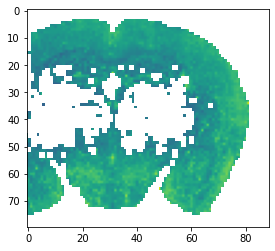

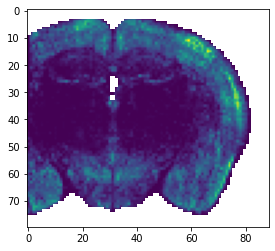

In [8]:
def plot_coronal(flat_array, y_idx, ax=None):
    arr = jnp.nan * jnp.zeros(alive_voxels.shape)
    arr = arr.at[alive_voxels].set(flat_array)

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    im = ax.imshow(arr[:, y_idx, :].T)
    return ax, im

vis_intensity = jnp.where(counts == 0, jnp.nan, intensity)

plot_coronal(vis_intensity[100], 50)
plot_coronal(counts[100], 50)

### Make random masks

Mask off hyperrectangles for each mouse.

In [9]:
# def make_masks(key, size, num_rect_per_mouse=3):
key = jr.PRNGKey(0)
size = 10
num_rect_per_mouse = 3

M, H, W, D = counts_3d.shape
masks_3d = jnp.ones_like(counts_3d, dtype=bool)

for m in trange(M):
    for i in range(num_rect_per_mouse):
        k1, k2, k3, key = jr.split(key, 4)
        x,y,z = jr.randint(k1, (3,), minval=jnp.zeros(3), maxval=jnp.array([H, W, D]))
        masks_3d = masks_3d.at[m, x:x+size, y:y+size, z:z+size].set(False)

masks = masks_3d[:, alive_voxels]


  0%|          | 0/168 [00:00<?, ?it/s]

(<Axes: >, <matplotlib.image.AxesImage at 0x7f09b453c280>)

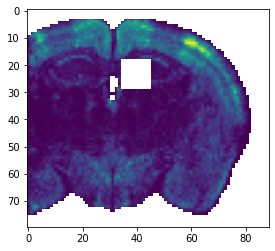

In [10]:
plot_coronal(jnp.where(masks[0], counts[0], jnp.nan), 50)

## Implement a simple log-linear Poisson model

In [11]:
import dataclasses
import jax
import jax.numpy as jnp
import warnings

from jax import tree_map
from jax.tree_util import tree_reduce
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
warnings.filterwarnings("ignore")


# Helper function to make a dataclass a JAX PyTree
def register_pytree_node_dataclass(cls):
  _flatten = lambda obj: jax.tree_flatten(dataclasses.asdict(obj))
  _unflatten = lambda d, children: cls(**d.unflatten(children))
  jax.tree_util.register_pytree_node(cls, _flatten, _unflatten)
  return cls


def convex_combo(pytree1, pytree2, stepsize):
    f = lambda x, y: (1 - stepsize) * x + stepsize * y
    return tree_map(f, pytree1, pytree2)


def tree_add(pytree1, pytree2, scale=1.0):
    return tree_map(lambda x, y: x + scale * y, pytree1, pytree2)


def tree_dot(pytree1, pytree2):
    return tree_reduce(jnp.add,
                       tree_map(lambda x, y: jnp.sum(x * y), pytree1, pytree2),
                       0.0)

In [12]:
import dataclasses
import jax.numpy as jnp
import jax.random as jr
import warnings

from jax import grad, hessian, vmap, lax, jit
from jax.nn import softplus
from jaxtyping import Array, Float
from tensorflow_probability.substrates import jax as tfp
from tqdm.auto import trange

tfd = tfp.distributions
warnings.filterwarnings("ignore")


@register_pytree_node_dataclass
@dataclasses.dataclass(frozen=True)
class SemiNMFParams:
    """
    Container for the model parameters
    """
    factors : Float[Array, "num_factors num_columns"]
    count_loadings : Float[Array, "num_rows num_factors"]
    count_row_effects : Float[Array, "num_rows"]
    count_col_effects : Float[Array, "num_columns"]
    intensity_loadings : Float[Array, "num_rows num_factors"]
    intensity_row_effects : Float[Array, "num_rows"]
    intensity_col_effects : Float[Array, "num_columns"]
    intensity_variance : Float[Array, "num_columns"]

    @property
    def num_factors(self):
        return self.factors.shape[0]


def soft_threshold(x, thresh):
    return jnp.sign(x) * jnp.maximum(jnp.abs(x) - thresh, 0.0)


def smooth_loss(params, counts, intensity, mask, mean_func):
    # -log p(counts | params)
    g = dict(softplus=softplus)[mean_func]
    count_means = g(params.count_row_effects[:, None] \
                    + params.count_col_effects \
                    + jnp.einsum('mk, kn->mn', params.count_loadings, params.factors))
    loss = jnp.where(mask, -tfd.Poisson(rate=count_means + 1e-8).log_prob(counts), 0.0).sum()

    # -log p(intensity | counts, params)
    intensity_means = params.intensity_row_effects[:, None] \
                    + params.intensity_col_effects \
                    + jnp.einsum('mk, kn->mn', params.intensity_loadings, params.factors)
    intensity_var = params.intensity_variance / (counts + 1e-8)
    loss += jnp.where(mask, -tfd.Normal(intensity_means, jnp.sqrt(intensity_var)).log_prob(intensity), 0.0).sum()
    return loss


grad_smooth_loss = grad(smooth_loss, argnums=0)


def penalty(params, sparsity_penalty, elastic_net_frac):
    loss = elastic_net_frac * sparsity_penalty * jnp.sum(abs(params.count_loadings))
    loss += 0.5 * (1 - elastic_net_frac) * sparsity_penalty * jnp.sum(params.count_loadings ** 2)
    loss += elastic_net_frac * sparsity_penalty * jnp.sum(abs(params.intensity_loadings))
    loss += 0.5 * (1 - elastic_net_frac) * sparsity_penalty * jnp.sum(params.intensity_loadings ** 2)
    return loss


@partial(jit, static_argnums=(4,))
def compute_loss(counts : Float[Array, "num_rows num_columns"],
                 intensity : Float[Array, "num_rows num_columns"],
                 mask : Float[Array, "num_rows num_columns"],
                 params : SemiNMFParams,
                 mean_func : str,
                 sparsity_penalty : float,
                 elastic_net_frac: float
                 ):
    loss = smooth_loss(params, counts, intensity, mask, mean_func)
    loss += penalty(params, sparsity_penalty, elastic_net_frac)
    return loss / counts.size


def heldout_loglike(counts : Float[Array, "num_rows num_columns"],
                    intensity : Float[Array, "num_rows num_columns"],
                    mask : Float[Array, "num_rows num_columns"],
                    params : SemiNMFParams,
                    mean_func : str):
    # -log p(counts | params)
    g = dict(softplus=softplus)[mean_func]
    count_means = g(params.count_row_effects[:, None] \
                    + params.count_col_effects \
                    + jnp.einsum('mk, kn->mn', params.count_loadings, params.factors))
    loss = jnp.where(~mask, tfd.Poisson(rate=count_means + 1e-8).log_prob(counts), 0.0).sum()

    # -log p(intensity | counts, params)
    intensity_means = params.intensity_row_effects[:, None] \
                    + params.intensity_col_effects \
                    + jnp.einsum('mk, kn->mn', params.intensity_loadings, params.factors)
    intensity_var = params.intensity_variance / (counts + 1e-8)
    loss += jnp.where(~mask, tfd.Normal(intensity_means, jnp.sqrt(intensity_var)).log_prob(intensity), 0.0).sum()
    return loss / counts.size



def backtracking_line_search(counts,
                             intensity,
                             mask,
                             params,
                             new_params,
                             mean_func,
                             sparsity_penalty,
                             elastic_net_frac,
                             alpha=0.5,
                             beta=0.5):
    # Precompute some constants
    dg = grad_smooth_loss(params, counts, intensity, mask, mean_func)
    descent_direction = tree_add(new_params, params, -1.0)
    dg_direc = tree_dot(dg, descent_direction)
    baseline = smooth_loss(params, counts, intensity, mask, mean_func)
    baseline += (1 - alpha) * penalty(params, sparsity_penalty, elastic_net_frac)

    def cond_fun(stepsize):
        new_params = tree_add(params, descent_direction, stepsize)
        new_loss = smooth_loss(new_params, counts, intensity, mask, mean_func)
        new_loss += penalty(new_params, sparsity_penalty, elastic_net_frac)
        bound = baseline + alpha * stepsize * dg_direc
        bound += alpha * penalty(new_params, sparsity_penalty, elastic_net_frac)
        return new_loss > bound

    def body_fun(stepsize):
        return beta * stepsize

    stepsize = lax.while_loop(cond_fun, body_fun, 1.0)
    return tree_add(params, descent_direction, stepsize)


@register_pytree_node_dataclass
@dataclasses.dataclass(frozen=True)
class QuadraticApprox:
    """
    Container for the model parameters
    """
    J_counts : Float[Array, "num_rows num_columns"]
    h_counts : Float[Array, "num_rows num_columns"]
    J_intensity : Float[Array, "num_rows num_columns"]
    h_intensity : Float[Array, "num_rows num_columns"]


def compute_quadratic_approx(counts, intensity, mask, params, mean_func):
    # Define key functions of the Poisson GLM
    A = jnp.exp                             # shorthand
    d2A = vmap(vmap(hessian(A)))            # want to broadcast scalar function to whole matrix

    if mean_func.lower() == "softplus":
        # Define numerically safe versions of log(softplus) and its gradients
        f = softplus
        log_softplus = lambda a: jnp.log(f(a))
        thresh = -10
        g = lambda a: jnp.where(a > thresh, log_softplus(a), a)
        dg = lambda a: jnp.where(a > thresh, vmap(vmap(grad(log_softplus)))(a), 1.0)
        d2g = lambda a: jnp.where(a > thresh, vmap(vmap(hessian(log_softplus)))(a), 0.0)
    else:
        raise Exception("invalid mean function: {}".format(mean_func))

    # Compute the quadratic approximation for the Poisson loss
    activations = params.count_row_effects[:, None] \
                + params.count_col_effects \
                + jnp.einsum('mk, kn->mn', params.count_loadings, params.factors)
    predictions = f(activations)
    J_counts = mask * (d2g(activations) * (predictions - counts) + (dg(activations))**2 * d2A(g(activations)))
    h_counts = mask * dg(activations) * (counts - predictions)

    # Compute the quadratic loss for the intensity
    predictions = params.intensity_row_effects[:, None] \
                + params.intensity_col_effects \
                + jnp.einsum('mk, kn->mn', params.intensity_loadings, params.factors)
    J_intensity = mask * counts / params.intensity_variance
    h_intensity = mask * counts / params.intensity_variance * (intensity - predictions)
    return QuadraticApprox(J_counts, h_counts, J_intensity, h_intensity)


def update_loadings(quad_approx,
                    params,
                    sparsity_penalty,
                    elastic_net_frac):
    """
    Update the loadings while holding the remaining parameters fixed.
    """
    def _update_one_loading(h_m, J_m, loading_m):
        """
        Coordinate descent to update the m-th loading
        """
        def _update_one_coord(h_m, args):
            """
            Update one coordinate of the m-th loading
            """
            loading_mk, factor_k = args

            # Compute the numerator (linear term) and denominator (quad term)
            # of the quadratic loss as a function of loading \beta_{mk}
            num = jnp.einsum('n,n->', factor_k, (h_m + J_m * loading_mk * factor_k))
            den = jnp.einsum('n,n,n->', J_m, factor_k, factor_k) + (1 - elastic_net_frac) * sparsity_penalty

            # Apply prox operator
            new_loading_mk = soft_threshold(num, elastic_net_frac * sparsity_penalty) / (den + 1e-8)

            # Update the weighted residual
            h_m += J_m * loading_mk * factor_k
            h_m -= J_m * new_loading_mk * factor_k
            return h_m, new_loading_mk

        # Scan over the (K,) dimension
        h_m, loading_m = lax.scan(_update_one_coord, h_m, (loading_m, params.factors))
        return h_m, loading_m

    # Update the count loadings
    h_counts, count_loadings = vmap(_update_one_loading)(quad_approx.h_counts, quad_approx.J_counts, params.count_loadings)

    # Update the intensity loadings
    h_intensity, intensity_loadings = vmap(_update_one_loading)(quad_approx.h_intensity, quad_approx.J_intensity, params.intensity_loadings)
    params = dataclasses.replace(params,
                                 count_loadings=count_loadings,
                                 intensity_loadings=intensity_loadings)

    quad_approx = dataclasses.replace(quad_approx,
                                      h_counts=h_counts,
                                      h_intensity=h_intensity)
    return quad_approx, params


def update_factors(quad_approx, params):
    """
    Update the factors while holding the remaining parameters fixed.
    """
    def _update_one_column(hc_n, Jc_n, hi_n, Ji_n, factor_n):
        """
        Coordinate descent to update the n-th column of all factors
        """
        def _update_one_coord(carry, args):
            r"""
            Update factor \theta_{nk}
            """
            hc_n, hi_n = carry
            factor_nk, count_loading_k, intensity_loading_k = args

            # Compute the numerator (linear term) and denominator (quad term)
            # of the quadratic loss as a function of factor \theta_{nk}
            num = jnp.einsum('m,m->', count_loading_k, (hc_n + Jc_n * factor_nk * count_loading_k))
            den = jnp.einsum('m,m,m->', Jc_n, count_loading_k, count_loading_k)

            # Add the contribution from the intensity
            num += jnp.einsum('m,m->', intensity_loading_k, (hi_n + Ji_n * factor_nk * intensity_loading_k))
            den += jnp.einsum('m,m,m->', Ji_n, intensity_loading_k, intensity_loading_k)

            # Apply prox operator to ensure loadings are non-negative
            new_factor_nk = jnp.maximum(num, 0.0) / (den + 1e-8)

            # Update weighted residuals
            hc_n += Jc_n * factor_nk * count_loading_k
            hc_n -= Jc_n * new_factor_nk * count_loading_k
            hi_n += Ji_n * factor_nk * intensity_loading_k
            hi_n -= Ji_n * new_factor_nk * intensity_loading_k
            return (hc_n, hi_n), new_factor_nk

        # Scan over the (K,) dimension
        (hc_n, hi_n), factor_n = \
            lax.scan(_update_one_coord,
                     (hc_n, hi_n),
                     (factor_n, params.count_loadings.T, params.intensity_loadings.T))

        return hc_n, hi_n, factor_n

    # Map over the (N,) dimension
    h_countsT, h_intensityT, factorsT = \
        vmap(_update_one_column)(quad_approx.h_counts.T,
                                 quad_approx.J_counts.T,
                                 quad_approx.h_intensity.T,
                                 quad_approx.J_intensity.T,
                                 params.factors.T)
    h_counts = h_countsT.T
    h_intensity = h_intensityT.T
    factors = factorsT.T

    # Make sure the factors are normalized
    scale = factors.sum(axis=1) + 1e-8
    factors /= scale[:, None]
    count_loadings = params.count_loadings * scale
    intensity_loadings = params.intensity_loadings * scale
    params = dataclasses.replace(params,
                                 factors=factors,
                                 count_loadings=count_loadings,
                                 intensity_loadings=intensity_loadings)
    quad_approx = dataclasses.replace(quad_approx, h_counts=h_counts, h_intensity=h_intensity)
    return quad_approx, params


def update_row_effect(quad_approx, params):
    """
    Update the row effect while holding the remaining parameters fixed.
    """
    def _update_one_row(h_m, J_m, row_effect_m):
        """
        Update the m-th row effect
        """
        # Compute the numerator (linear term) and denominator (quad term)
        # of the quadratic loss as a function of loading b_{m}
        num = jnp.einsum('n->', h_m + J_m * row_effect_m)
        den = jnp.einsum('n->', J_m)
        new_row_effect_m = num / den

        # Update residual
        h_m += J_m * row_effect_m
        h_m -= J_m * new_row_effect_m
        return h_m, new_row_effect_m

    # Update the row effects for the count data
    h_counts, count_row_effects = \
        vmap(_update_one_row)(quad_approx.h_counts, quad_approx.J_counts, params.count_row_effects)

    # Do the same for the intensity
    h_intensity, intensity_row_effects = \
        vmap(_update_one_row)(quad_approx.h_intensity, quad_approx.J_intensity, params.intensity_row_effects)

    params = dataclasses.replace(params,
                                 count_row_effects=count_row_effects,
                                 intensity_row_effects=intensity_row_effects)
    quad_approx = dataclasses.replace(quad_approx,
                                      h_counts=h_counts,
                                      h_intensity=h_intensity)
    return quad_approx, params


def update_column_effect(quad_approx, params):
    """
    Update the row effect while holding the remaining parameters fixed.
    """
    def _update_one_column(h_n, J_n, col_effect_n):
        """
        Update the n-th column effect
        """
        # Compute the numerator (linear term) and denominator (quad term)
        # of the quadratic loss as a function of loading c_{n}
        num = jnp.einsum('m->', h_n + J_n * col_effect_n)
        den = jnp.einsum('m->', J_n)
        new_col_effect_n = num / den

        # Update residual
        h_n += J_n * col_effect_n
        h_n -= J_n * new_col_effect_n
        return h_n, new_col_effect_n

    # Update the column effects for the counts
    h_intensityT, count_col_effects = \
        vmap(_update_one_column)(quad_approx.h_counts.T,
                                 quad_approx.J_counts.T,
                                 params.count_col_effects)
    h_counts = h_intensityT.T

    # Do the same for the intensity
    h_intensityT, intensity_col_effects = \
        vmap(_update_one_column)(quad_approx.h_intensity.T,
                                 quad_approx.J_intensity.T,
                                 params.intensity_col_effects)
    h_intensity = h_intensityT.T

    # Make sure column effects sum to zero
    mean = jnp.mean(count_col_effects)
    count_col_effects -= mean
    count_row_effects = params.count_row_effects + mean
    mean = jnp.mean(intensity_col_effects)
    intensity_col_effects -= mean
    intensity_row_effects = params.intensity_row_effects + mean

    params = dataclasses.replace(params,
                                 count_row_effects=count_row_effects,
                                 count_col_effects=count_col_effects,
                                 intensity_row_effects=intensity_row_effects,
                                 intensity_col_effects=intensity_col_effects)
    quad_approx = dataclasses.replace(quad_approx,
                                      h_counts=h_counts,
                                      h_intensity=h_intensity)
    return quad_approx, params


def update_emission_noise_var(counts, 
                              intensity,
                              mask,
                              params,
                              alpha=0.0001, 
                              beta=0.0001):
    """Update the emission noise variance via coordinate ascent.
    """
        # Compute the quadratic loss for the intensity
    predictions = params.intensity_row_effects[:, None] \
                + params.intensity_col_effects \
                + jnp.einsum('mk, kn->mn', params.intensity_loadings, params.factors)
    residual = intensity - predictions

    alpha_post = alpha + 0.5 * jnp.sum((mask * counts) > 0, axis=0)
    beta_post = beta + 0.5 * jnp.sum(mask * counts * residual**2, axis=0)
    # return beta_post / (alpha_post + 1)
    intensity_variance = beta_post / alpha_post
    return dataclasses.replace(params, intensity_variance=intensity_variance)


def initialize_random(key, data, num_factors, mean_func):
    m, n = data.shape

    # Convert data to "targets" by inverting mean function
    if mean_func.lower() == "softplus":
        data = jnp.maximum(data, 1e-1)
        targets = data + jnp.log(1 - jnp.exp(-data))
    else:
        raise Exception("Invalid mean function: {}".format(mean_func))

    # Initialize the row and column effects
    row_effects = targets.mean(axis=1)
    col_effects = jnp.zeros(n)

    # initialie the factors randomly
    factors = jr.exponential(key, shape=(num_factors, n))
    factors /= factors.sum(axis=1, keepdims=True)
    loadings = jnp.zeros((m, num_factors))
    return SemiNMFParams(loadings, factors, row_effects, col_effects)


def initialize_nnsvd(counts, intensity, num_factors, mean_func, drugs=None):
    """Initialize the model with an SVD. Project the right singular vectors
    onto the non-negative orthant.
    """
    # Convert data to "targets" by inverting mean function
    if mean_func.lower() == "softplus":
        pseudocounts = jnp.maximum(counts, 1e-1)
        # y = log(1 + e^{x})  ->  x = log(e^y - 1) = y + log(1 - e^{-y})
        targets = pseudocounts + jnp.log(1 - jnp.exp(-pseudocounts))
    else:
        raise Exception("Invalid mean function: {}".format(mean_func))

    num_mice = counts.shape[0]
    shape = counts.shape[1:]

    # Initialize the row- and column-effects
    count_row_effect = jnp.mean(targets, axis=1)
    targets -= count_row_effect[:, None]

    if drugs is not None:
        # !!!!HACK!!!!! Leaking information about drugs into column effect
        count_col_effect = targets[drugs == 10].mean(axis=0)
    else:
        count_col_effect = targets.mean(axis=0)
    targets -= count_col_effect

    # Now run SVD on the residual
    U, S, VT = jnp.linalg.svd(targets.reshape(num_mice, -1), full_matrices=False)

    # flip signs on factors so that each has non-negative mean
    count_loadings = []
    factors = []
    for uk, sk, vk in zip(U.T[:num_factors], S[:num_factors], VT[:num_factors]):
        sign = jnp.sign(vk.mean())
        # sign = 1.0
        vk = jnp.clip(vk * sign, a_min=1e-8)
        scale = vk.sum()
        factors.append((vk / scale).reshape(shape))
        count_loadings.append(uk * sk * scale * sign )

    count_loadings = jnp.column_stack(count_loadings)
    factors = jnp.stack(factors)

    # Now compute intensity loadings using factors from the counts
    targets = jnp.where(counts > 0, intensity, 0.0)
    intensity_row_effect = jnp.sum(counts * targets, axis=1) / jnp.sum(counts, axis=1)
    targets -= intensity_row_effect[:, None]
    if drugs is not None:
        # !!!!HACK!!!!! Leaking information about drugs into column effect
        # intensity_col_effect = targets[drugs == 10].mean(axis=0)
        pass
    else:
        intensity_col_effect = jnp.sum(counts * targets, axis=0) / jnp.sum(counts, axis=0)
    targets -= intensity_col_effect

    # Solve for the intensity loading with a simple linear regression
    # y_m ~ \theta^T @ \beta_m -> \beta_m* = (\theta \theta^T)^{-1} \theta y_m
    # intensity_loadings = jnp.linalg.solve(factors @ factors.T, factors @ targets.T).T
    intensity_loadings = jnp.linalg.solve(
        jnp.einsum('mn, jn, kn->mjk', counts, factors, factors),
        jnp.einsum('mn, mn, kn->mk', counts, targets, factors))
    # intensity_loadings = jnp.einsum('mn,mn,kn->mk', counts, targets, factors) / jnp.einsum('mn, kn, kn->mk', counts, factors, factors)
    assert jnp.all(jnp.isfinite(intensity_loadings))

    # TODO: Compute the intensity variance
    intensity_variance = 1.0 * jnp.ones(shape)

    return SemiNMFParams(factors,
                         count_loadings,
                         count_row_effect,
                         count_col_effect,
                         intensity_loadings,
                         intensity_row_effect,
                         intensity_col_effect,
                         intensity_variance)



def fit_poisson_seminmf(counts,
                        intensity,
                        initial_params,
                        mask=None,
                        mean_func="softplus",
                        num_iters=10,
                        sparsity_penalty=1.0,
                        elastic_net_frac=0.0,
                        num_coord_ascent_iters=20,
                        tolerance=1e-1,
                        ):

    # Make mask if necessary
    mask = jnp.ones_like(counts) if mask is None else mask
    assert mask.shape == counts.shape

    @jit
    def _step(params, _):
        """
        One sweep over parameter updates
        """
        # Update rows
        quad_approx = compute_quadratic_approx(counts, intensity, mask, params, mean_func)
        def _row_step(carry, _):
            quad_approx, params = carry
            quad_approx, params = update_loadings(quad_approx, params, sparsity_penalty, elastic_net_frac)
            quad_approx, params = update_row_effect(quad_approx, params)
            return (quad_approx, params), None
        (quad_approx, new_params), _ = lax.scan(_row_step, (quad_approx, params), None, length=num_coord_ascent_iters)
        params = backtracking_line_search(counts, intensity, mask, params, new_params, mean_func, sparsity_penalty, elastic_net_frac)

        # Update columns
        quad_approx = compute_quadratic_approx(counts, intensity, mask, params, mean_func)
        def _column_step(carry, _):
            quad_approx, params = carry
            quad_approx, params = update_factors(quad_approx, params)
            # quad_approx, params = update_column_effect(quad_approx, params)
            return (quad_approx, params), None
        (_, new_params), _ = lax.scan(_column_step, (quad_approx, params), None, length=num_coord_ascent_iters)
        params = backtracking_line_search(counts, intensity, mask, params, new_params, mean_func, sparsity_penalty, elastic_net_frac)

        # Update variance
        params = update_emission_noise_var(counts, intensity, mask, params)
        
        loss = compute_loss(counts, intensity, mask, params, mean_func, sparsity_penalty, elastic_net_frac)
        hll = heldout_loglike(counts, intensity, mask, params, mean_func)
        return params, loss, hll

    # Run coordinate ascent
    params = initial_params
    losses = [compute_loss(counts, intensity, mask, params, mean_func, sparsity_penalty, elastic_net_frac)]
    hlls = [heldout_loglike(counts, intensity, mask, params, mean_func)]
    pbar = progress_bar(range(num_iters))
#     breakpoint()
    for itr in pbar:
        params, loss, hll = _step(params, itr)
        losses.append(loss)
        hlls.append(hll)
        assert jnp.isfinite(loss)
#         print("loss: {:.4f}".format(losses[-1]))
        pbar.comment = "loss: {:.4f}".format(losses[-1])

        if abs(losses[-1] - losses[-2]) < tolerance:
            break

    return params, jnp.stack(losses), jnp.stack(hlls)


## Select number of factors by cross validation

In [13]:
mean_func = "softplus"
sparsity_penalty = 1e-2
elastic_net_frac = 1.0
num_iters = 200
num_coord_ascent_iters = 1

# Compute the SVD initialization once
max_num_factors = 30
full_initial_params = initialize_nnsvd(counts, intensity, max_num_factors, mean_func, drugs=None)

# Fit the model
all_num_factors = jnp.arange(2, max_num_factors+1, 2)
all_heldout_loglikes = []
for num_factors in all_num_factors:
    print("fitting model with", num_factors, "factors")
    initial_params = dataclasses.replace(
        full_initial_params,
        factors=full_initial_params.factors[:num_factors],
        count_loadings=full_initial_params.count_loadings[:, :num_factors],
        intensity_loadings=full_initial_params.intensity_loadings[:, :num_factors],
    )

    params, losses, heldout_loglikes = \
        fit_poisson_seminmf(counts,
                            intensity,
                            initial_params,
                            mask=masks,
                            mean_func=mean_func,
                            sparsity_penalty=sparsity_penalty,
                            elastic_net_frac=elastic_net_frac,
                            num_iters=num_iters,
                            num_coord_ascent_iters=num_coord_ascent_iters,
                            tolerance=1e-5
                            )

    all_heldout_loglikes.append(heldout_loglikes[-1])

all_heldout_loglikes = jnp.array(all_heldout_loglikes)

fitting model with 2 factors


fitting model with 4 factors


fitting model with 6 factors


fitting model with 8 factors


fitting model with 10 factors


fitting model with 12 factors


fitting model with 14 factors


fitting model with 16 factors


fitting model with 18 factors


fitting model with 20 factors


fitting model with 22 factors


fitting model with 24 factors


fitting model with 26 factors


fitting model with 28 factors


fitting model with 30 factors


Text(0, 0.5, 'heldout log like')

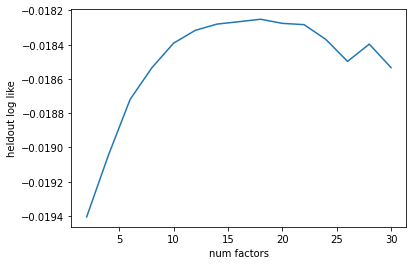

In [14]:
plt.plot(all_num_factors, all_heldout_loglikes)
plt.xlabel("num factors")
plt.ylabel("heldout log like")

In [15]:
best_num_factors = all_num_factors[jnp.argmax(all_heldout_loglikes)]
print("Optimal number of factors:", best_num_factors)


Optimal number of factors: 18


## Fit model with a chosen number of factors on all data

In [16]:
initial_params = initialize_nnsvd(counts, intensity, best_num_factors, mean_func, drugs=None)

In [17]:
sparsity_penalty = 1e-2
elastic_net_frac = 1.0
num_iters = 200
num_coord_ascent_iters = 1

print("fitting model with", best_num_factors, "factors")
params, losses, heldout_loglikes = \
    fit_poisson_seminmf(counts,
                        intensity,
                        initial_params,
                        mask=None,
                        mean_func=mean_func,
                        sparsity_penalty=sparsity_penalty,
                        elastic_net_frac=elastic_net_frac,
                        num_iters=num_iters,
                        num_coord_ascent_iters=num_coord_ascent_iters,
                        tolerance=1e-5
                        )

fitting model with 18 factors


Text(0, 0.5, 'loss')

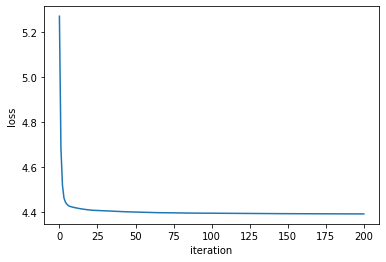

In [18]:
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")

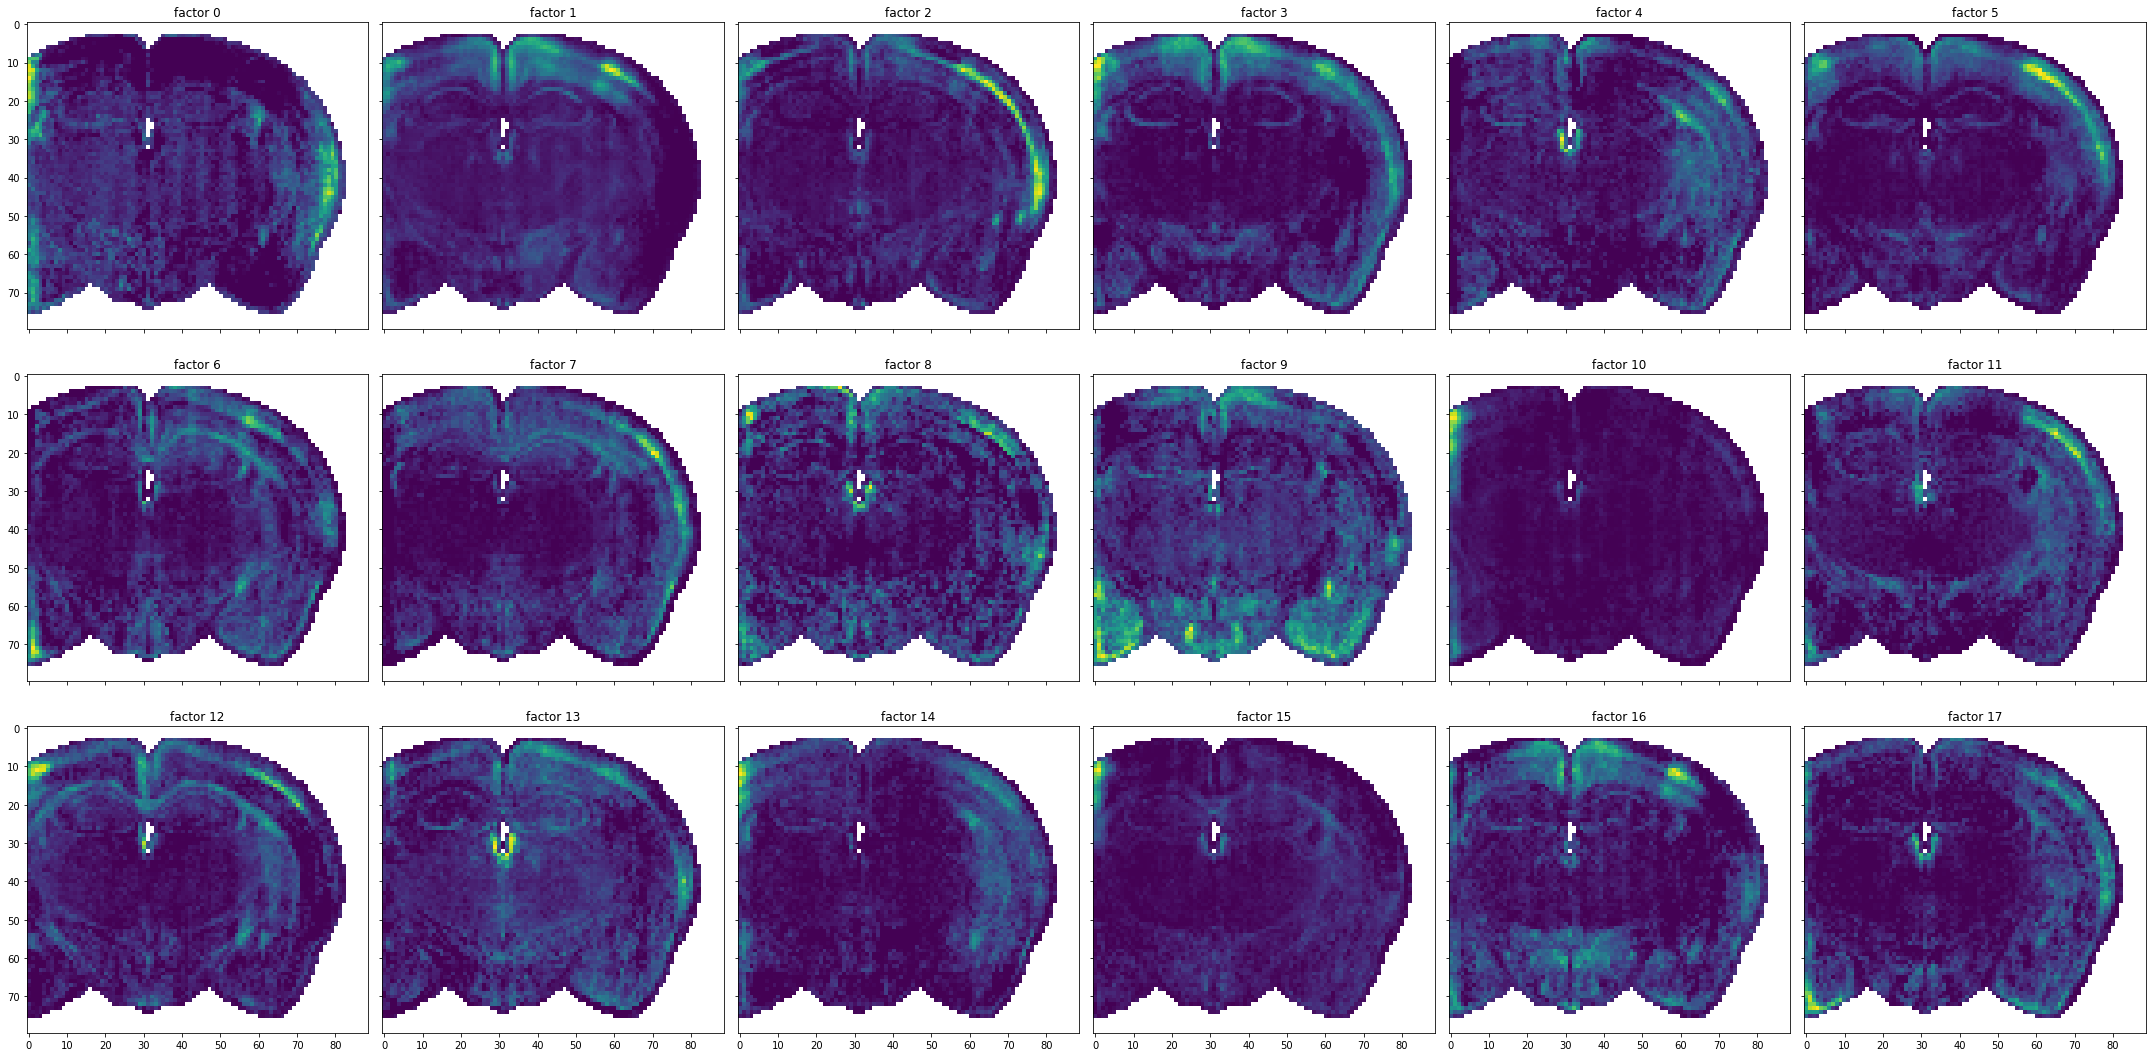

In [76]:
fig, axs = plt.subplots(3, 6, figsize=(30, 15), sharey=True, sharex=True)
for k, ax in enumerate(axs.ravel()):
    if k < best_num_factors:
        plot_coronal(params.factors[k], y_idx=50, ax=ax)
        ax.set_title("factor {}".format(k))
    else:
        ax.set_visible(False)
        
plt.tight_layout()

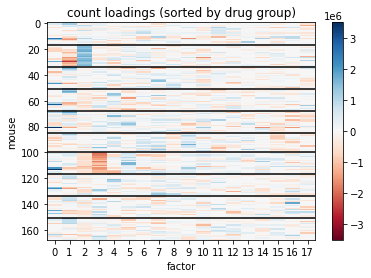

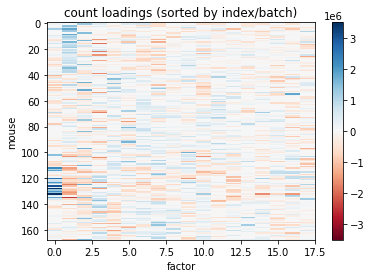

In [53]:
perm = jnp.argsort(drugs)
bounds = jnp.cumsum(jnp.bincount(drugs)[1:-1])

loadings = params.count_loadings
vmax = abs(loadings).max()

plt.imshow(loadings[perm], vmin=-vmax, vmax=vmax, cmap="RdBu", aspect="auto", interpolation="none")
for bound in bounds:
    plt.axhline(bound, color='k')
_ = plt.xticks(np.arange(best_num_factors))

plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("count loadings (sorted by drug group)")
plt.colorbar()

plt.figure()
plt.imshow(loadings, aspect="auto", cmap="RdBu", vmin=-vmax, vmax=vmax, interpolation="none")
plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("count loadings (sorted by index/batch)")
plt.colorbar()

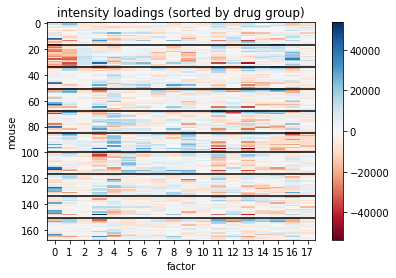

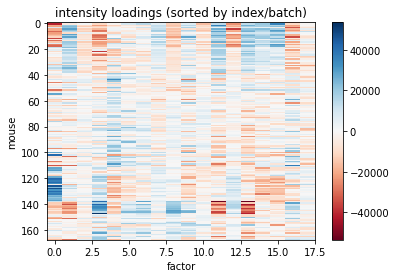

In [26]:
perm = jnp.argsort(drugs)
bounds = jnp.cumsum(jnp.bincount(drugs)[1:-1])

loadings = params.intensity_loadings
vmax = abs(loadings).max()

plt.imshow(loadings[perm], vmin=-vmax, vmax=vmax, cmap="RdBu", aspect="auto", interpolation="none")
for bound in bounds:
    plt.axhline(bound, color='k')
_ = plt.xticks(np.arange(best_num_factors))

plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("intensity loadings (sorted by drug group)")
plt.colorbar()

plt.figure()
plt.imshow(loadings, aspect="auto", cmap="RdBu", vmin=-vmax, vmax=vmax, interpolation="none")
plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("intensity loadings (sorted by index/batch)")
plt.colorbar()

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# normalize weights and factors
def normalize_weights(weights):
    U = weights
    U = U - U.mean()
    U /= U.std()
    return(U)

def downstream_task(W, drugs, **kwargs):
    """
    kwargs
    ------
    cv: pass in the same CV splitter for both the grid search and the confusion matrix
    """
#     W_norm = normalize_weights(W)
    W_norm = W
    parameters = {"C":10 ** np.linspace(-15,15,num=31)}
    lr = LogisticRegression()
    gridsearch = GridSearchCV(lr, parameters, **kwargs)
    gridsearch.fit(W_norm, drugs)
    drug_clf_acc = gridsearch.best_score_
    classifier = gridsearch.best_estimator_
    drugs_pred = cross_val_predict(classifier, W_norm, y=drugs, **kwargs)
    confusion_mat = confusion_matrix(drugs, drugs_pred)
    return(classifier, drug_clf_acc, confusion_mat)

0.5005347593582887


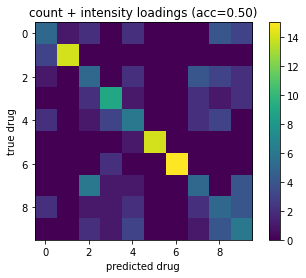

In [92]:
features = jnp.hstack([normalize_weights(params.count_loadings),
                       normalize_weights(params.intensity_loadings),
                      ])
cv = KFold(shuffle=True, random_state=0)
clf, acc, cmat = downstream_task(features, drugs, cv=cv)

print(acc)
plt.imshow(cmat)
plt.ylabel("true drug")
plt.xlabel("predicted drug")
plt.title("count + intensity loadings (acc={:.2f})".format(acc))
plt.colorbar()

0.47023172905525845


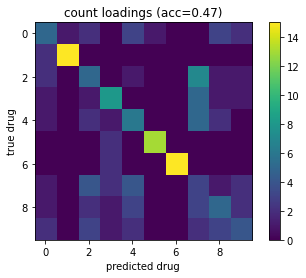

In [93]:
features = jnp.hstack([normalize_weights(params.count_loadings),
#                        normalize_weights(params.intensity_loadings),
                      ])
cv = KFold(shuffle=True, random_state=0)
clf, acc, cmat = downstream_task(features, drugs, cv=cv)

print(acc)
plt.imshow(cmat)
plt.ylabel("true drug")
plt.xlabel("predicted drug")
plt.title("count loadings (acc={:.2f})".format(acc))
plt.colorbar()

0.45204991087344026


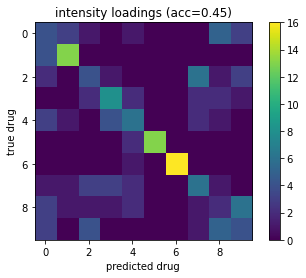

In [94]:
features = jnp.hstack([normalize_weights(params.intensity_loadings),
                      ])
cv = KFold(shuffle=True, random_state=0)
clf, acc, cmat = downstream_task(features, drugs, cv=cv)

print(acc)
plt.imshow(cmat)
plt.ylabel("true drug")
plt.xlabel("predicted drug")
plt.title("intensity loadings (acc={:.2f})".format(acc))
plt.colorbar()

Text(0.5, 1.0, 'estimated intensity variance')

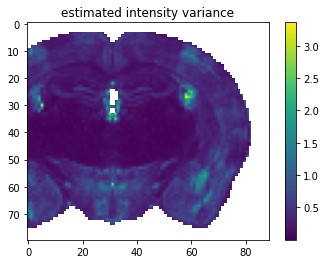

In [23]:
ax, im = plot_coronal(params.intensity_variance, 50)
plt.colorbar(im)
ax.set_title("estimated intensity variance")

Text(0.5, 1.0, 'average weight per voxel')

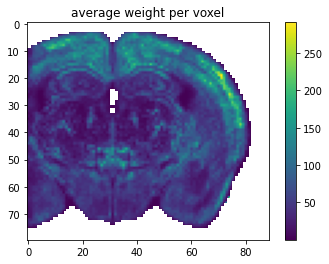

In [86]:
ax, im = plot_coronal((counts.mean(axis=0)) / params.intensity_variance, 50)
# im.set_clim(0, 1)
plt.colorbar(im)
ax.set_title("average weight per voxel")

## Sort factors by decoding importance

### Single feature decoding

In [49]:
from fastprogress.fastprogress import master_bar, progress_bar

accs = -jnp.inf * jnp.ones(best_num_factors)
for j in progress_bar(range(best_num_factors)):
    features = params.count_loadings[:,j:j+1]
    features = normalize_weights(features)
    cv = KFold(shuffle=True, random_state=0)
    _, acc, _ = downstream_task(features, drugs, cv=cv)
    accs = accs.at[j].set(acc)

jnp.argsort(accs)[::-1]

Array([ 2,  5,  3, 15,  8,  9, 10,  1,  4, 12, 13,  0, 14, 17,  6, 16,  7,
       11], dtype=int32)

### Greedy Forward
Use a greedy forward procedure where we build up the model one feature at a time, adding the feature that most improves the classification accuracy. Intuitively, we expect this approach to yield an ordering that is similar to the norm of the weights of the full decoder, but that's not strictly guaranteed.

In [47]:
from fastprogress.fastprogress import master_bar, progress_bar

indices = jnp.array([], dtype=int)

mb = master_bar(range(best_num_factors))        
for i in mb:
    accs = -jnp.inf * jnp.ones(best_num_factors)
    for j in progress_bar(range(best_num_factors), parent=mb):
        if j not in indices:
            features = jnp.column_stack([params.count_loadings[:,indices],
                                         params.count_loadings[:,j]])
            features = normalize_weights(features)
            cv = KFold(shuffle=True, random_state=0)
            _, acc, _ = downstream_task(features, drugs, cv=cv)
            accs = accs.at[j].set(acc)
            
    best_j = jnp.argmax(accs)
    indices = jnp.insert(indices, 0, best_j)
#     indices = jnp.concatenate([indices, jnp.array([best_j])])
    

In [48]:
indices[::-1]

Array([ 2,  9,  5,  4,  7,  6,  3,  1, 10, 13,  8, 15, 17,  0, 12, 11, 16,
       14], dtype=int32)

### Leave one out accuracy

How much does performance drop when we leave out one feature?

In [34]:
loo_acc = []


for k in progress_bar(range(best_num_factors)):
    
    features = jnp.hstack([params.count_loadings[:,:k],
                           params.count_loadings[:,k+1:]])
    features = normalize_weights(features)
    cv = KFold(shuffle=True, random_state=0)
    _, acc, _ = downstream_task(features, drugs, cv=cv)
    loo_acc.append(acc)
    
loo_acc = jnp.array(loo_acc)

In [51]:
jnp.argsort(loo_acc)

Array([ 2,  8,  5,  7, 10, 15,  6,  0, 13, 12,  9, 17,  1, 16,  4, 11,  3,
       14], dtype=int32)

In [36]:
features = normalize_weights(params.count_loadings)
cv = KFold(shuffle=True, random_state=0)
_, full_acc, _ = downstream_task(features, drugs, cv=cv)

<BarContainer object of 18 artists>

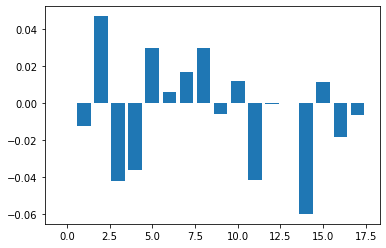

In [38]:
plt.bar(jnp.arange(best_num_factors), full_acc - loo_acc)

### Look at normalized features

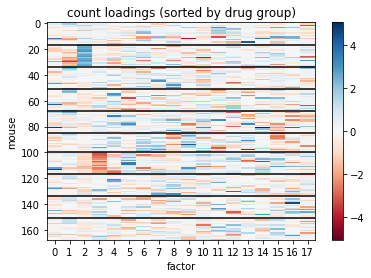

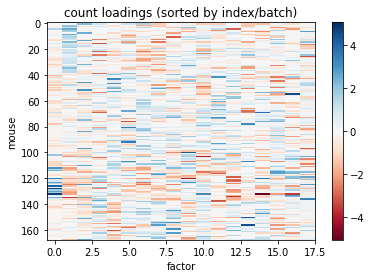

In [52]:
perm = jnp.argsort(drugs)
bounds = jnp.cumsum(jnp.bincount(drugs)[1:-1])

loadings = params.count_loadings
loadings -= loadings.mean(axis=0)
loadings /= loadings.std(axis=0)
vmax = abs(loadings).max()

plt.imshow(loadings[perm], vmin=-vmax, vmax=vmax, cmap="RdBu", aspect="auto", interpolation="none")
for bound in bounds:
    plt.axhline(bound, color='k')
_ = plt.xticks(np.arange(best_num_factors))

plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("count loadings (sorted by drug group)")
plt.colorbar()

plt.figure()
plt.imshow(loadings, aspect="auto", cmap="RdBu", vmin=-vmax, vmax=vmax, interpolation="none")
plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("count loadings (sorted by index/batch)")
plt.colorbar()

## Save factors to tiff stack

In [ ]:
# im = ax.imshow(arr[:, y_idx, :].T)

In [ ]:
# def save_factor(factor, filename):
#     arr = jnp.zeros(alive_voxels.shape)
#     arr = arr.at[alive_voxels].set(factor)
    
#     for 
#     imsave(filename, arr)
    
# for k, factor in enumerate(params.factors):
#     save_factor(params.factors[2], os.path.join("2023_11_01_outputs", "factor{}.tif".format(k)))

### Experimenting with tifffile

In [61]:
!pip install tifffile

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 6.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [62]:
from tifffile import imsave

In [66]:
!mkdir 2023_11_01_outputs

In [74]:
def save_factor(factor, filename):
    arr = jnp.zeros(alive_voxels.shape)
    arr = arr.at[alive_voxels].set(factor)
    arr = jnp.transpose(arr, (1, 2, 0))
    arr /= arr.max()
    imsave(filename, arr)
    
for k, factor in enumerate(params.factors):
    save_factor(factor, os.path.join("2023_11_01_outputs", "factor{}.tif".format(k)))

In [70]:
!ls -lh 2023_11_01_outputs/

total 53M
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:17 factor0.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor10.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor11.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor12.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor13.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor14.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor15.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor16.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor17.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:17 factor1.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:17 factor2.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor3.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor4.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor5.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor6.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor7.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor8.tif
-rw-rw-r-- 1 swl1 swl1 2.6M Nov  1 22:18 factor9.tif


In [65]:
!pwd

/home/groups/swl1/swl1/cfos/notebooks
